In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
import random
from os import environ 
import matplotlib.pyplot as plt
import seaborn as sns
from components import *

In [2]:
# Insure reproducibility and set device

def seed_everything(seed=42):
    random.seed(seed)
    environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()
    
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')

print(device)

OUTPUT_PATH = './Model'

cuda:0


## Dataset and pre-processing

In [3]:
df = pd.read_csv("./Data/complete_dataset.csv")

In [4]:
"""
Processed and assembled dataset. Engineered features (using intraday data):

pDemand - positive share of daily demand
pRRP    - volume-averaged price of daily positively-priced demand
nDemand - negative share of daily demand
nRRP    - volume-averaged price of daily negatively-priced demand
FracNegative - fraction of total demand at negative price

Note, all these featers are used only in encoder part (past) of the model.
Decoder part uses information about date and weather only (known in advance).
"""
df.head()

,Date,Demand,RRP,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature,SchoolDay,Holiday
0,2015-01-01,99635.030,25.633696,97319.240,25.801974,2315.790,-0.168277,0.020833,13.3,26.9,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,36.283366,8523.995,-3.144378,0.062500,15.4,38.8,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,N,N


In [5]:
df['SchoolDay'] = df['SchoolDay'].map({'N' : 0, 'Y' : 1})
df['Holiday'] = df['Holiday'].map({'N' : 0, 'Y' : 1})

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['DoW_cos'] = df['Date'].apply(lambda x: np.cos(2*np.pi*x.dayofweek/7))
df['DoW_sin'] = df['Date'].apply(lambda x: np.sin(2*np.pi*x.dayofweek/7))
df['WoY_cos'] = df['Date'].apply(lambda x: np.cos(2*np.pi*x.weekofyear/52))
df['WoY_sin'] = df['Date'].apply(lambda x: np.sin(2*np.pi*x.weekofyear/52))
df['Year'] = df['Date'].dt.year
df['Year'] = (df['Year'] - df['Year'].min())/(df['Year'].max() - df['Year'].min())
df

,Date,Demand,RRP,pDemand,pRRP,nDemand,nRRP,FracNegative,Minimum Temperature,Maximum Temperature,SchoolDay,Holiday,DoW_cos,DoW_sin,WoY_cos,WoY_sin,Year
0,2015-01-01,99635.030,25.633696,97319.240,25.801974,2315.790,-0.168277,0.020833,13.3,26.9,0,1,-0.900969,0.433884,0.992709,0.120537,0.0
1,2015-01-02,129606.010,33.138988,121082.015,36.283366,8523.995,-3.144378,0.062500,15.4,38.8,0,0,-0.900969,-0.433884,0.992709,0.120537,0.0
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,0,0,-0.222521,-0.974928,0.992709,0.120537,0.0
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,0,0,0.623490,-0.781831,0.992709,0.120537,0.0
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,0,0,1.000000,0.000000,0.970942,0.239316,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,11.375646,57597.595,-17.451675,0.625000,12.8,26.0,0,0,-0.900969,-0.433884,0.120537,-0.992709,1.0
2102,2020-10-03,92277.025,-1.983471,44133.510,15.514259,48143.515,-17.497730,0.583333,17.4,29.4,0,0,-0.222521,-0.974928,0.120537,-0.992709,1.0
2103,2020-10-04,94081.565,25.008614,88580.995,25.018147,5500.570,-0.009534,0.062500,13.5,29.5,0,0,0.623490,-0.781831,0.120537,-0.992709,1.0
2104,2020-10-05,113610.030,36.764701,106587.375,37.167203,7022.655,-0.402503,0.083333,9.1,12.7,0,0,1.000000,0.000000,0.239316,-0.970942,1.0


Validation set will start from this point.

In [7]:
val_start_id = df[df['Date'] == pd.to_datetime('01-01-2019')].index[0]

Test set will start from this point. If the model works well on valid set, any discrepancies between the data and the model may serve as a leading indicator of changing a economic outlook.

In [8]:
test_start_id = df[df['Date'] == pd.to_datetime('01-01-2020')].index[0]

In [9]:
# Final part of preprocessing - feature scaling

from sklearn.preprocessing import StandardScaler

raw_cols = ['Minimum Temperature', 'Maximum Temperature', 
              'FracNegative', 'nRRP', 'pRRP', 
              'nDemand', 'pDemand']

scaled_cols = [col + " (sc)" for col in raw_cols]

# using function for demand rather than scaler helps to avoid numpy conversion from torch.Tensor
train_demand = df[:val_start_id][['Demand']].values
mean = train_demand.mean()
std = train_demand.std()
def demand_scaler(x):
    return (x - mean)/std

scaler = StandardScaler()

scaler.fit(df[:val_start_id][raw_cols])

df[scaled_cols] = scaler.transform(df[raw_cols])
df['Demand (sc)'] = demand_scaler(df[['Demand']].values)

In [10]:
train_df = df[:val_start_id]
val_df = df[val_start_id-14:test_start_id]
test_df = df[test_start_id-14:]

In [11]:
ignore_columns = ['Date', 'RRP', 'pDemand', 'pRRP', 'nDemand', 'nRRP', 'FracNegative']
decoder_columns = ['Minimum Temperature (sc)', 'Maximum Temperature (sc)', 'SchoolDay', 
                   'Holiday', 'DoW_cos', 'DoW_sin', 'WoY_cos', 'WoY_sin', 'Year']
encoder_columns = decoder_columns + ['Demand (sc)', 'pDemand (sc)', 
                                     'pRRP (sc)', 'nDemand (sc)', 'nRRP (sc)', 'FracNegative (sc)']

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, num_enc_features, num_dec_features, hidden_size, tgt_scaler=None,
                 num_enc_layers = 1, enc_droupout=0.1, dec_droupout=0.1):
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(num_enc_features, hidden_size, 
                               num_enc_layers, enc_droupout)
        self.decoder = Decoder(num_dec_features, hidden_size, dec_droupout)
        # Target scaler is applied to last prediction when feeding forward
        self.tgt_scaler = tgt_scaler
        self.hidden = None
        
    def forward(self, enc_batch, dec_batch, forcing = 0):
        """
        teacher forcing = 0 amounts can be used for inference.
        teacher forcing > 0 is a training mode.
        """
        output_enc, hidden_enc = self.encoder(enc_batch, self.hidden)
        
        hidden_dec = hidden_enc
        
        pred = torch.zeros((dec_batch.shape[0], dec_batch.shape[1], 1), device=dec_batch.device)
        
        for t, dec_inp, in enumerate(dec_batch.transpose(0, 1)):               
            output, hidden_dec = self.decoder(dec_inp, hidden_dec)            
            pred[:, t, :] = output
            
        return pred
    
    
    def init_hidden(self, batch_size, device):
        # Important!! Run before forward()
        self.hidden = self.encoder.init_hidden(batch_size).to(device)

### Load pre-trained model

In [13]:
RNN_UNITS = 100
BATCH_SIZE = 20
TARGET_WIDTH = 7

num_enc_features = len(encoder_columns)
num_dec_features = len(decoder_columns)

tgt_scaler = demand_scaler

w = WindowGenerator(input_width=14, target_width=TARGET_WIDTH, 
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    ignore_columns = ignore_columns,
                    target_columns=['Demand'], 
                    encoder_columns=encoder_columns, 
                    decoder_columns=decoder_columns)

model = Seq2Seq(num_enc_features, num_dec_features, hidden_size = RNN_UNITS, 
                enc_droupout=0, dec_droupout=0.1, tgt_scaler = tgt_scaler)

model = model.to(device)

model.eval()
load_checkpoint(OUTPUT_PATH + '/model.pkl', model, device)

7182.245334201389

In [14]:
def evaluate(model, df, win_gen):
    """
    Evaluate on a whole dataframe. 
    For every time point save forecast for the following "target_width" points
    """
    model.eval()
    model.init_hidden(1, device)
    
    win_gen.prep_extern_data(df, set_source = 'all_data')
    
    ids = win_gen.gen_batches(batch_size = 1, source = 'all_data')
    print(len(df))
    
    DType = torch.FloatTensor
    
    all_losses = []
    all_pred = []
    
    with torch.no_grad():  
        for i, idx in enumerate(ids):
            all_enc, all_dec, all_tgt = win_gen.batch(idx, source='all_data')
            all_enc = torch.from_numpy(all_enc).type(DType).to(device)
            all_dec = torch.from_numpy(all_dec).type(DType).to(device)
            all_tgt = torch.from_numpy(all_tgt).type(DType).to(device)
                                    
            y_pred = model(all_enc, all_dec)
            all_pred.append(y_pred.squeeze().cpu().numpy())
            
    return np.array(all_pred)

In [15]:
pred = evaluate(model, df, w)

2106


In [16]:
demo_df = df.copy()
demo_df['Demand'] = demo_df['Demand']/1000
demo_df = demo_df.drop([col for col in demo_df.columns if col[-4:] == "(sc)"], axis=1)
for i in range(pred.shape[-1]):
    demo_df[f'Day_{i+1}'] = np.zeros(len(demo_df))
    demo_df.iloc[14 + i:-7 + i, len(demo_df.columns) - 1] = pred[:, i]/1000

In [17]:
sns.set_style("whitegrid")

## Plotting demand forecast and actual demand for 2019 and 2020

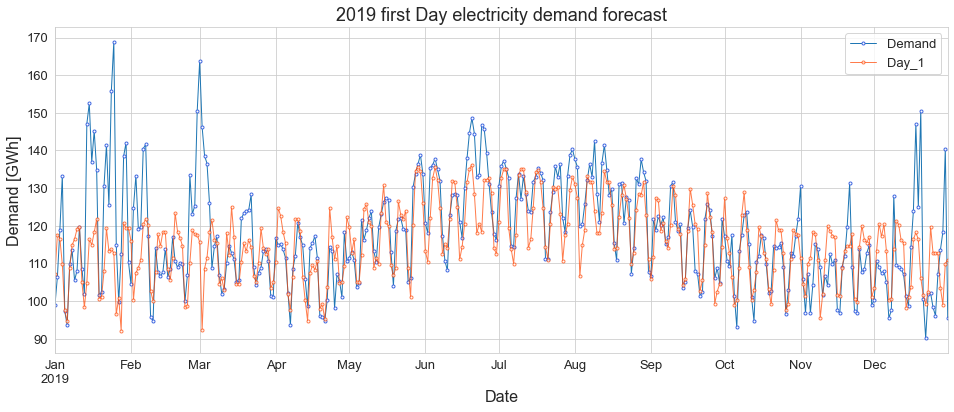

In [18]:
params = {'axes.labelsize': 16,
              'axes.titlesize': 18,
              'font.size': 13}
plt.rcParams.update(params)

marker_D = {'marker' : 'o', 'markeredgewidth': 1, 'markerfacecolor' : 'white',
          'markersize' : 3, 'markevery' : 1, 'markeredgecolor': 'royalblue'}

color_7 = 'maroon'
color_1 = 'orangered'
marker_F = {'marker' : 'o', 'markeredgewidth': 1, 'markerfacecolor' : 'white',
          'markersize' : 3, 'markevery' : 1, 'markeredgecolor': color_1}

fig, ax = plt.subplots(1, 1, figsize = (16, 6))
demo_df[val_start_id:test_start_id].plot(x = "Date", y="Demand", **marker_D, lw=1, ax = ax)
demo_df[val_start_id:test_start_id].plot(x = "Date", y="Day_1", lw=1, **marker_F, alpha=0.7, ax = ax, c='orangered')
ax.set_title("2019 first Day electricity demand forecast")
ax.set_ylabel("Demand [GWh]")

plt.savefig("./Plots+/2019_day_1.png", dpi=300)
None

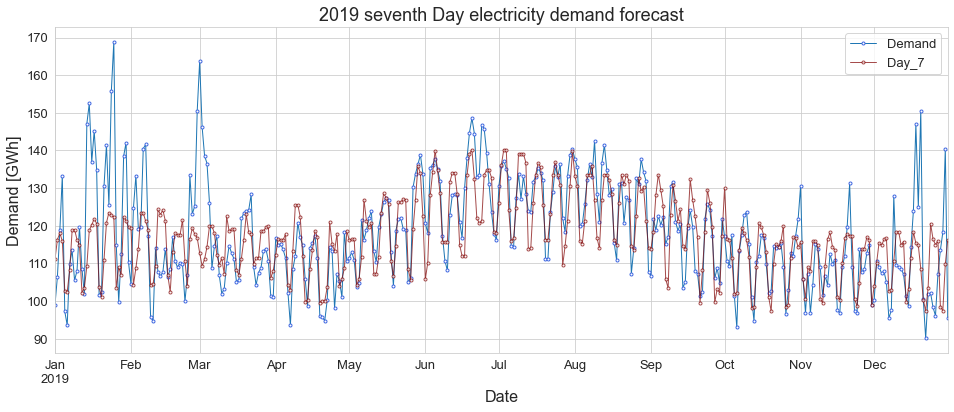

In [20]:
marker_F = {'marker' : 'o', 'markeredgewidth': 1, 'markerfacecolor' : 'white',
          'markersize' : 3, 'markevery' : 1, 'markeredgecolor': color_7}

fig, ax = plt.subplots(1, 1, figsize = (16, 6))
demo_df[val_start_id:test_start_id].plot(x = "Date", y="Demand", **marker_D, lw=1, ax = ax)
demo_df[val_start_id:test_start_id].plot(x = "Date", y="Day_7", lw=1, **marker_F, alpha=0.7, ax = ax, c='maroon')
ax.set_title("2019 seventh Day electricity demand forecast")
ax.set_ylabel("Demand [GWh]")

plt.savefig("./Plots+/2019_day_7.png", dpi=300)
None

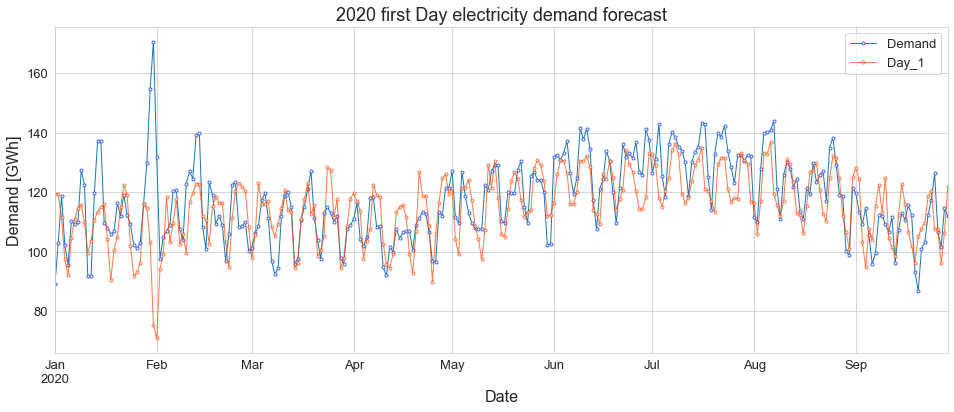

In [21]:
marker_F = {'marker' : 'o', 'markeredgewidth': 1, 'markerfacecolor' : 'white',
          'markersize' : 3, 'markevery' : 1, 'markeredgecolor': color_1}

fig, ax = plt.subplots(1, 1, figsize = (16, 6))
demo_df[test_start_id:-7].plot(x = "Date", y="Demand", **marker_D, lw=1, ax = ax)
demo_df[test_start_id:-7].plot(x = "Date", y="Day_1", lw=1, **marker_F, alpha=0.7, ax = ax, c='orangered')
ax.set_title("2020 first Day electricity demand forecast")
ax.set_ylabel("Demand [GWh]")

plt.savefig("./Plots+/2020_day_1.png", dpi=300)
None

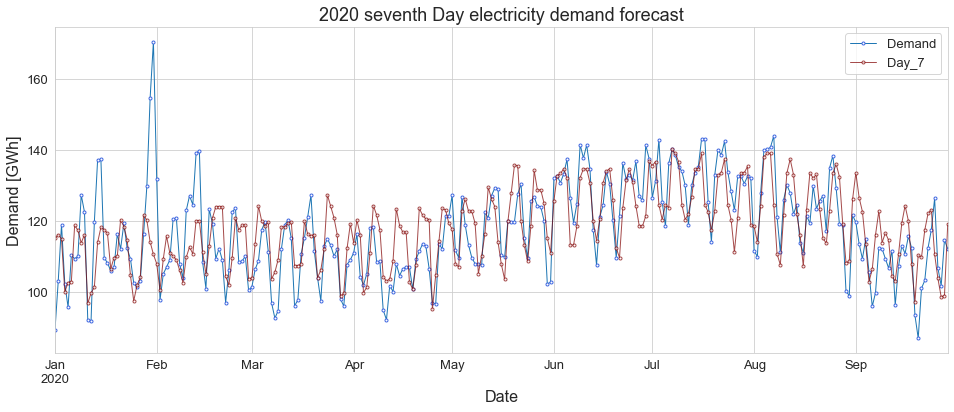

In [22]:
marker_F = {'marker' : 'o', 'markeredgewidth': 1, 'markerfacecolor' : 'white',
          'markersize' : 3, 'markevery' : 1, 'markeredgecolor': color_7}

fig, ax = plt.subplots(1, 1, figsize = (16, 6))
demo_df[test_start_id:-7].plot(x = "Date", y="Demand", **marker_D, lw=1, ax = ax)
demo_df[test_start_id:-7].plot(x = "Date", y="Day_7", lw=1, **marker_F, alpha=0.7, ax = ax, c='maroon')
ax.set_title("2020 seventh Day electricity demand forecast")
ax.set_ylabel("Demand [GWh]")

plt.savefig("./Plots+/2020_day_7.png", dpi=300)
None

In [23]:
sns.set_style('ticks')

Text(0.5, 0, 'error magnitude, %')

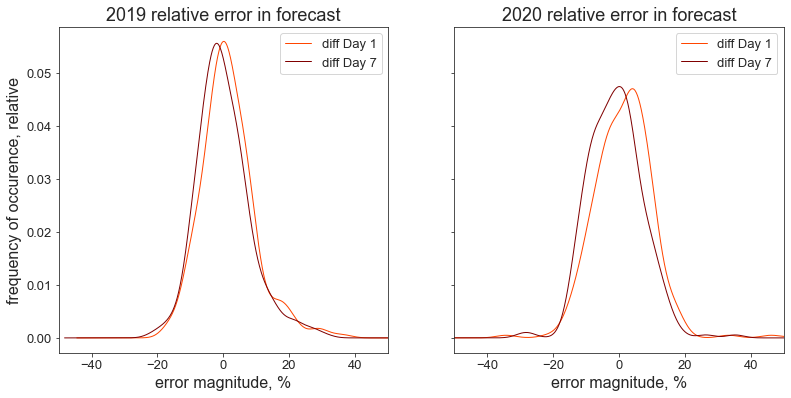

In [24]:
for i in range(7):
    demo_df[f'diff Day {i+1}'] = 100*(1 - demo_df[f'Day_{i+1}']/demo_df['Demand'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharey=True)

demo_df[val_start_id:test_start_id].plot(x = "Date", y="diff Day 1", ax = ax1, lw = 1, c='orangered', kind='density')
demo_df[val_start_id:test_start_id].plot(x = "Date", y="diff Day 7", ax = ax1, lw = 1, c='maroon', kind='density')
demo_df[test_start_id:-7].plot(x = "Date", y="diff Day 1", ax = ax2, lw = 1, c='orangered', kind='density')
demo_df[test_start_id:-7].plot(x = "Date", y="diff Day 7", ax = ax2, lw = 1, c='maroon', kind='density')
ax1.set_xlim(-50, 50)
ax2.set_xlim(-50, 50)
ax1.set_title("2019 relative error in forecast")
ax2.set_title("2020 relative error in forecast")
ax1.set_ylabel("frequency of occurence, relative")
ax1.set_xlabel("error magnitude, %")
ax2.set_xlabel("error magnitude, %")

Text(0.5, 0, 'magnitude, %')

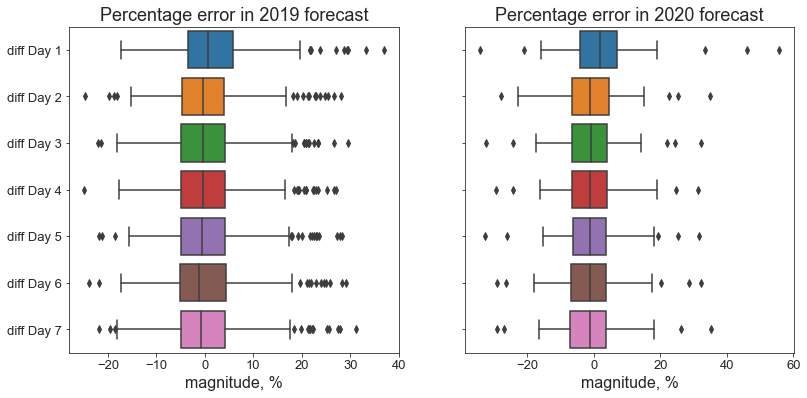

In [25]:
sns.set_style('ticks')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharey=True)

sns.boxplot(data=demo_df[val_start_id:test_start_id][[f"diff Day {i+1}" for i in range(7)]], ax=ax1, orient='h')
ax1.set_title("Percentage error in 2019 forecast")

sns.boxplot(data=demo_df[test_start_id:-7][[f"diff Day {i+1}" for i in range(7)]], ax=ax2, orient='h')
ax2.set_title("Percentage error in 2020 forecast")

ax1.set_xlabel("magnitude, %")
ax2.set_xlabel("magnitude, %")

#plt.savefig("error.png", dpi=300)

In [26]:
mape = [[demo_df[val_start_id:test_start_id][f"diff Day {i+1}"].apply(lambda x: np.abs(x)).mean().round(2) for i in range(7)]]
mape += [[demo_df[test_start_id:-7][f"diff Day {i+1}"].apply(lambda x: np.abs(x)).mean().round(2) for i in range(7)]]
mape = pd.DataFrame(data = mape, columns=[f'Day {i+1}' for i in range(7)], index = [2019, 2020])
mape

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7
2019,6.11,5.93,5.95,6.05,6.04,6.08,6.07
2020,6.83,6.55,6.21,6.21,6.22,6.39,6.39


In [27]:
mape.to_csv("Plots+/MAPE.csv")